# Example 12 - Loading SigMF files
This notebook shows how users can read in their own SigMF files as a dataset.

----

## Import Libraries

In [5]:
# TorchSig
from torchsig.datasets.sigmf_datasets import SigMFDataset
from torchsig.datasets.synthetic import ConstellationBasebandModulator

# Third Party
import sigmf
from sigmf import SigMFFile
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp

# Built-In
import os
import datetime as dt

Below is code to generate some sample SigMF data and metadata files for a QPSK signal.

In [6]:
# Variables
dataset_path = "./datasets/12_example"

# name of signal to generate, must be valid name within TorchSig QAM/PSK/ASK/OOK class list
class_name = 'qpsk'

In [7]:
def create_sigmf_files(class_name:str):

    # base filename
    filename = f"{dataset_path}/{class_name}_in_noise"

    # duration (in samples)
    num_iq_samples = 10000

    # define center frequency of the signal
    center_freq = 0.15

    # samples per symbol and signal bandwidth for QAM/PSK signals have an inverse relationship
    samples_per_symbol = 16
    bandwidth = 1/samples_per_symbol

    # calculate the upper and lower frequency for the signal
    upper_freq = center_freq + (bandwidth/2)
    lower_freq = center_freq - (bandwidth/2)

    # define the alpha roll-off of srrc pulse shaping filter
    alpha_rolloff = 0.25

    # create a QPSK signal at complex baseband
    signal = ConstellationBasebandModulator ( class_name=class_name, excess_bandwidth=alpha_rolloff, iq_samples_per_symbol=samples_per_symbol, num_iq_samples=num_iq_samples )
    # frequency shift signal
    signal *= np.exp(2j*np.pi*center_freq*np.arange(num_iq_samples))
    # create noise
    noise = 1e-3*(np.random.normal(0,1,num_iq_samples) + 1j*np.random.normal(0,1,num_iq_samples))
    # received signal is signal with noise
    received_signal = signal + noise

    # filename to write IQ data
    data_filename = f"{filename}.sigmf-data"
    # write the binary file
    received_signal.astype(np.complex64).tofile(data_filename)
   
    # note that TorchSig 0.6.x uses an implied normalized sampling rate of 1 which
    # gives the frequency bounds of -fs/2 to fs/2 to be within -1/2 to 1/2.
    # therefore all fields such as center frequency, bandwidth, upper frequency
    # lower frequency, etc. all need to be within such bounds.
    #
    # a forthcoming update is being developed to allow TorchSig to accept sampling rates
    # other than 1, but as such is not yet supported within the current codebase.
    
    # create the metadata
    meta = SigMFFile(
        data_file=f"{filename}.sigmf-data", # extension is optional
        global_info = {
            SigMFFile.DATATYPE_KEY: 'cf32_le', # 32-bit complex-float, little-endian which matches binary file write tofile() call prior
            SigMFFile.SAMPLE_RATE_KEY: 1,
            SigMFFile.AUTHOR_KEY: 'Example 12',
            SigMFFile.DESCRIPTION_KEY: f'Simulation of {class_name} with noise',
            SigMFFile.VERSION_KEY: sigmf.__version__,
        }
    )

    # create a capture key
    meta.add_capture(
        0, # starting at time index 0
        metadata={
            SigMFFile.FREQUENCY_KEY: 0, # represents the receiver center frequency, this field will be ignored within TorchSig
            SigMFFile.DATETIME_KEY: dt.datetime.now(dt.timezone.utc).isoformat(),
    })

    # an annotation in SigMF defines the "bounding box" information of start/stop time
    # and upper/lower frequency used in TorchSig
    meta.add_annotation(
        0, # starting at time index 0
        length=num_iq_samples, # duration of the signal
        metadata={
            SigMFFile.FLO_KEY: lower_freq,
            SigMFFile.FHI_KEY: upper_freq,
            SigMFFile.LABEL_KEY: class_name
        }
    )

    # check for mistakes and write to disk
    meta.validate()

    meta.tofile(f"{filename}.sigmf-meta")

    print(f"files created at {dataset_path}")

os.makedirs(dataset_path, exist_ok=True)

# create the SigMF file
create_sigmf_files(class_name)

files created at ./datasets/12_example


## Create SigMF Dataset
Using `SigMFDataset` to create a dataset of Signal objects from the SigMF files.

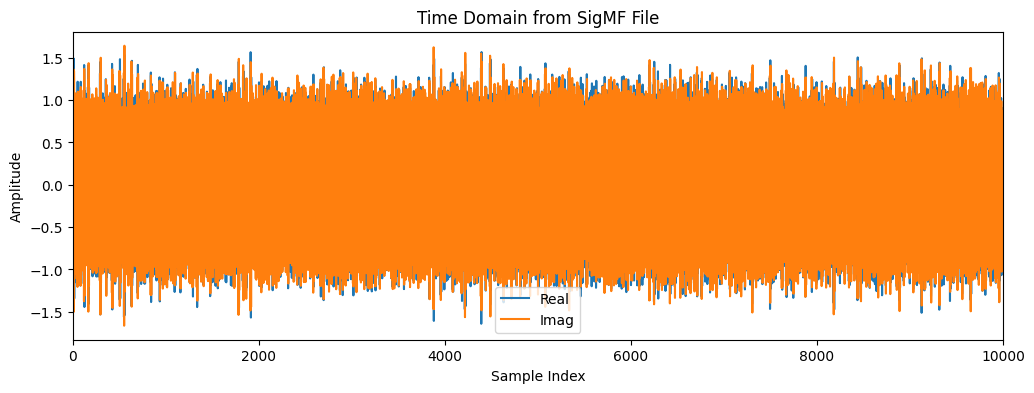

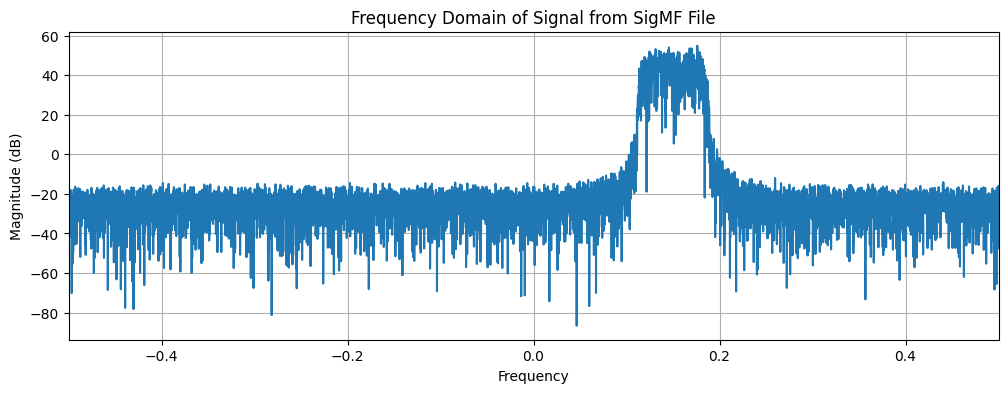

In [9]:
ds = SigMFDataset(
        data_path=dataset_path,
        class_list=[class_name],
        shuffle=False,
    )

ds[0]

# pull the IQ samples and plot to verify
signal_from_file = ds[0][0]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.real(signal_from_file),label='Real')
ax.plot(np.imag(signal_from_file),label='Imag')
ax.set_title('Time Domain from SigMF File')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Amplitude')
ax.set_xlim([0,len(signal_from_file)])
ax.legend()

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
fft_size = 2**20
f = np.linspace(-0.5,0.5-(1/fft_size),fft_size)
win = sp.windows.blackmanharris(len(signal_from_file))
ax.plot(f,20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(signal_from_file*win,fft_size)))))
ax.set_title('Frequency Domain of Signal from SigMF File')
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude (dB)')
ax.set_xlim(f[0],f[-1])
ax.grid()

plt.show()
